# 1 Introduction

First we going to copy the code from the exercise sheet and are going to edit it to allow for GPU training and testing

In [33]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

#set device for potential GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Cuda available: {}".format(torch.cuda.is_available()))

plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    # move variable to GPU
    w = w.to(device)
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])

Cuda available: True


100.0%


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw


100.0%


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw




100.0%
100.0%


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



Epoch: 0
Mean Train Loss: 3.93e-01
Mean Test Loss:  1.81e-01
Epoch: 10
Mean Train Loss: 1.50e-01
Mean Test Loss:  2.48e-01
Epoch: 20
Mean Train Loss: 1.02e-01
Mean Test Loss:  4.01e-01
Epoch: 30
Mean Train Loss: 8.79e-02
Mean Test Loss:  4.63e-01
Epoch: 40
Mean Train Loss: 4.16e-02
Mean Test Loss:  6.06e-01
Epoch: 50
Mean Train Loss: 3.63e-02
Mean Test Loss:  6.33e-01
Epoch: 60
Mean Train Loss: 3.40e-02
Mean Test Loss:  1.03e+00
Epoch: 70
Mean Train Loss: 3.10e-02
Mean Test Loss:  8.84e-01
Epoch: 80
Mean Train Loss: 1.79e-02
Mean Test Loss:  9.77e-01
Epoch: 90
Mean Train Loss: 1.11e-02
Mean Test Loss:  8.56e-01
Epoch: 100
Mean Train Loss: 1.12e-02
Mean Test Loss:  9.18e-01


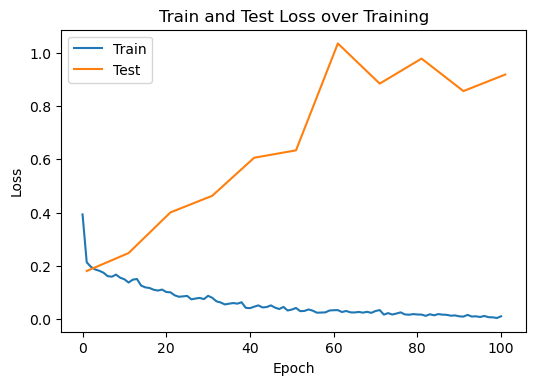

In [34]:
# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # Move data to the GPU device
        x = x.to(device)
        y = y.to(device)

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                # Move data to the GPU device
                x = x.to(device)
                y = y.to(device)

                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

# Move the model parameters back to the CPU device
w_h = w_h.cpu()
w_h2 = w_h2.cpu()
w_o = w_o.cpu()

train_loss = [loss.item() for loss in train_loss]
test_loss = [loss.item() for loss in test_loss]

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


# 2 Dropout

In [42]:
def dropout(X, p_drop=0.5):
    if 0 < p_drop < 1:
        mask = torch.bernoulli(torch.full(X.shape, 1 - p_drop, device=device))
        X_drop = torch.where(mask == 1, torch.zeros_like(X), X) / (1 - p_drop)
        return X_drop
    else:
        return X

In [36]:
def dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    x_drop = dropout(x, p_drop_input)
    h = rectify(x_drop @ w_h)
    h_drop = dropout(h, p_drop_hidden)
    h2 = rectify(h_drop @ w_h2)
    h2_drop = dropout(h2, p_drop_hidden)
    pre_softmax = h2_drop @ w_o
    
    return pre_softmax

Task: Explain in a few sentences how the dropout method works and how it reduces overfitting.

Answer: During training, dropout randomly sets a fraction of input units or hidden units to zero at each update, effectively "dropping out" those units. This prevents the model from relying to heavily on specific input or hidden units, as they are sometimes "dropped out". During testing you obviously dont apply dropout. Instead you scale the input units units with the factor of 1-p_drop to compensate for the missing dropout.

Task: Why do we need a different model configuration for evaluating the test loss? 

Answer: During testing you obviously dont apply dropout, as this only leaves out information and simply wouldnt make any sense. Instead you scale the input units units with the factor of 1-p_drop to compensate for the missing dropout.


In [37]:
def test_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):

    scaled_x = (1 - p_drop_input) * x
    h = rectify(scaled_x @ w_h)
    scaled_h = (1 - p_drop_hidden) * h
    h2 = rectify(scaled_h @ w_h2)
    scaled_h2 = (1 - p_drop_hidden) * h2
    pre_softmax = scaled_h2 @ w_o
    
    return pre_softmax

Epoch: 0
Mean Train Loss: 1.06e+00
Mean Test Loss:  4.44e-01
Epoch: 10
Mean Train Loss: 8.77e-01
Mean Test Loss:  2.99e-01
Epoch: 20
Mean Train Loss: 1.08e+00
Mean Test Loss:  3.13e-01
Epoch: 30
Mean Train Loss: 1.23e+00
Mean Test Loss:  3.38e-01
Epoch: 40
Mean Train Loss: 1.32e+00
Mean Test Loss:  3.07e-01
Epoch: 50
Mean Train Loss: 1.39e+00
Mean Test Loss:  2.88e-01
Epoch: 60
Mean Train Loss: 1.44e+00
Mean Test Loss:  3.56e-01
Epoch: 70
Mean Train Loss: 1.54e+00
Mean Test Loss:  3.33e-01
Epoch: 80
Mean Train Loss: 1.54e+00
Mean Test Loss:  3.18e-01
Epoch: 90
Mean Train Loss: 1.62e+00
Mean Test Loss:  3.45e-01
Epoch: 100
Mean Train Loss: 1.66e+00
Mean Test Loss:  3.54e-01


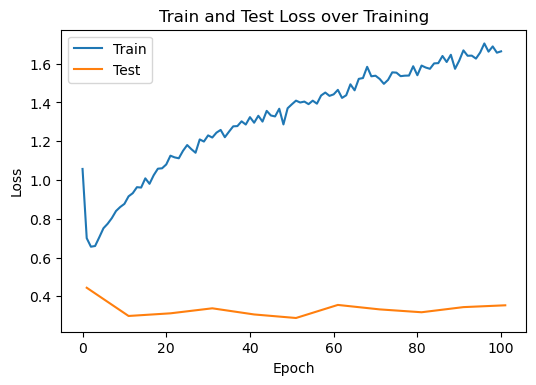

In [43]:
# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

p_drop_input = 0.4
p_drop_hidden = 0.4

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # Move data to the GPU device
        x = x.to(device)
        y = y.to(device)

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                # Move data to the GPU device
                x = x.to(device)
                y = y.to(device)

                x = x.reshape(batch_size, 784)
                noise_py_x = test_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")
# Move the model parameters back to the CPU device
w_h = w_h.cpu()
w_h2 = w_h2.cpu()
w_o = w_o.cpu()

train_loss = [loss.item() for loss in train_loss]
test_loss = [loss.item() for loss in test_loss]

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Task: Compare the test error with the test error from Section 1.

Answer: 

The training error in Section 1 is continously decreasing, even during the last epochs. However, the test error in Section 1 even increases slightly over time. This is a clear indication that the model overfits on the training data.

The training error in the Section with dropout doesnt really converge. The test error decreases slightly over time and is overall better than in the run without the dropout. This is a clear indication, that the model is better than the one from section 1 and does not overfit on the training data.

# 3 Parametric Relu

First we are going to create a PRelu layer by mapping $X \rightarrow  PRelu(X)$

In [29]:
def PRelu(X,a):
    return torch.max(torch.zeros_like(X), X) + a * torch.min(torch.zeros_like(X), X)

Now we are going to incorporate the parameter a into the params list and optimize them during training

Epoch: 0
Mean Train Loss: 4.34e-01
Mean Test Loss:  1.65e-01
Epoch: 10
Mean Train Loss: 1.10e-01
Mean Test Loss:  2.60e-01
Epoch: 20
Mean Train Loss: 7.73e-02
Mean Test Loss:  2.02e-01
Epoch: 30
Mean Train Loss: 6.30e-02
Mean Test Loss:  3.26e-01
Epoch: 40
Mean Train Loss: 4.77e-02
Mean Test Loss:  3.47e-01
Epoch: 50
Mean Train Loss: 3.88e-02
Mean Test Loss:  3.80e-01
Epoch: 60
Mean Train Loss: 3.96e-02
Mean Test Loss:  4.28e-01
Epoch: 70
Mean Train Loss: 3.94e-02
Mean Test Loss:  4.28e-01
Epoch: 80
Mean Train Loss: 2.82e-02
Mean Test Loss:  4.65e-01
Epoch: 90
Mean Train Loss: 3.22e-02
Mean Test Loss:  4.84e-01
Epoch: 100
Mean Train Loss: 2.92e-02
Mean Test Loss:  4.69e-01


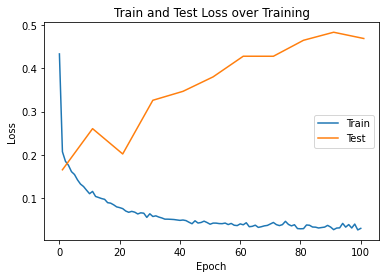

In [30]:
# define the neural network
def model(x, w_h, w_h2, w_o, a):
    h = PRelu(x @ w_h, a)
    h2 = PRelu(h @ w_h2, a)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)


# initialize PRelu parameter a with 0.25 according to paper
# http://arxiv.org/pdf/1502.01852.pdf
a = torch.tensor([0.25], requires_grad=True, device=device)


optimizer = RMSprop(params=[w_h, w_h2, w_o, a])
#optimizer = optimizer.to(device)

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # Move data to the GPU device
        x = x.to(device)
        y = y.to(device)

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o, a)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                # Move data to the GPU device
                x = x.to(device)
                y = y.to(device)

                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o, a)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")


# Move the model parameters back to the CPU device
w_h = w_h.cpu()
w_h2 = w_h2.cpu()
w_o = w_o.cpu()
a = a.cpu()

train_loss = [loss.item() for loss in train_loss]
test_loss = [loss.item() for loss in test_loss]

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 4 Convolutional layers

In [44]:
def convolution_layer(previous_layer, weightvector, p_drop):
    convolutional_layer = rectify(conv2d(previous_layer, weightvector))
    
    # reduces (2 ,2) window to 1 pixel
    subsample_layer = max_pool2d(convolutional_layer, (2, 2))
    out_layer = dropout(subsample_layer, p_drop_input)
    
    return out_layer

def model(x, w_conv_1, w_conv_2, w_conv_3, w_h2, w_o, p_drop_input, p_drop_hidden):
    #print(x.shape) # [100, 1, 28, 28]
    h_conv_1 = convolution_layer(x, w_conv_1, p_drop_input)
    #print(h_conv_1.shape) # [100, 32, 12, 12]
    h_conv_2 = convolution_layer(h_conv_1, w_conv_2, p_drop_hidden)
    #print(h_conv_2.shape) # [100, 64, 4, 4]
    h_conv_3 = convolution_layer(h_conv_2, w_conv_3, p_drop_hidden)
    #print(h_conv_3.shape)  # [100, 128, 1, 1]
    h_conv_3 = h_conv_3.reshape(100, -1)
    #print(h_conv_3.shape)  # [100, 128]
    h2 = rectify(h_conv_3 @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

def test_model(x, w_conv_1, w_conv_2, w_conv_3, w_h2, w_o):
    #dropout of -1 means no dropout
    h_conv_1 = convolution_layer(x, w_conv_1, -1)
    h_conv_2 = convolution_layer(h_conv_1, w_conv_2, -1)
    h_conv_3 = convolution_layer(h_conv_2, w_conv_3, -1)
    h_conv_3 = h_conv_3.reshape(100, -1)

    h2 = rectify(h_conv_3 @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

w_conv_1 = init_weights((32, 1, 5, 5))
w_conv_2 = init_weights((64, 32, 5, 5))
w_conv_3 = init_weights((128, 64, 2, 2))

number_of_output_pixel = 128
# hidden layer with 625 neurons
w_h2 = init_weights((number_of_output_pixel, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_conv_1, w_conv_2, w_conv_3, w_h2, w_o])

Epoch: 0
Mean Train Loss: 2.89e+00
Mean Test Loss:  1.58e+00
Epoch: 10
Mean Train Loss: 5.69e-01
Mean Test Loss:  5.37e-01
Epoch: 20
Mean Train Loss: 4.68e-01
Mean Test Loss:  4.26e-01
Epoch: 30
Mean Train Loss: 4.46e-01
Mean Test Loss:  4.34e-01
Epoch: 40
Mean Train Loss: 4.55e-01
Mean Test Loss:  3.99e-01
Epoch: 50
Mean Train Loss: 4.80e-01
Mean Test Loss:  4.01e-01
Epoch: 60
Mean Train Loss: 5.26e-01
Mean Test Loss:  4.63e-01
Epoch: 70
Mean Train Loss: 5.80e-01
Mean Test Loss:  4.77e-01
Epoch: 80
Mean Train Loss: 6.32e-01
Mean Test Loss:  5.50e-01
Epoch: 90
Mean Train Loss: 6.76e-01
Mean Test Loss:  5.86e-01
Epoch: 100
Mean Train Loss: 7.58e-01
Mean Test Loss:  6.91e-01


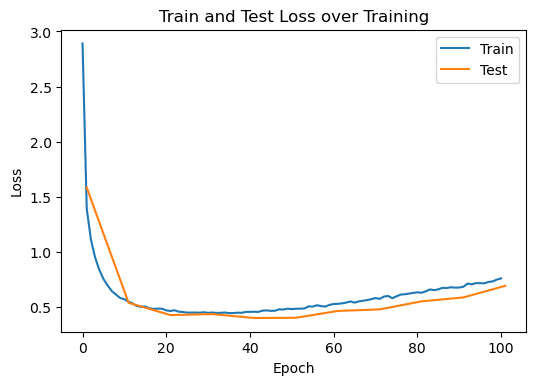

In [45]:
n_epochs = 100
p_drop_input = 0.4
p_drop_hidden = 0.4
train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # Move data to the GPU device
        x = x.to(device)
        y = y.to(device)

        #print(x.shape)
        # our model requires flattened input
        #x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_conv_1, w_conv_2, w_conv_3, w_h2, w_o, p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                # Move data to the GPU device
                x = x.to(device)
                y = y.to(device)

                #x = x.reshape(batch_size, 784)
                noise_py_x = test_model(x, w_conv_1, w_conv_2, w_conv_3, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()